
# **QUESTION 1 PART A**




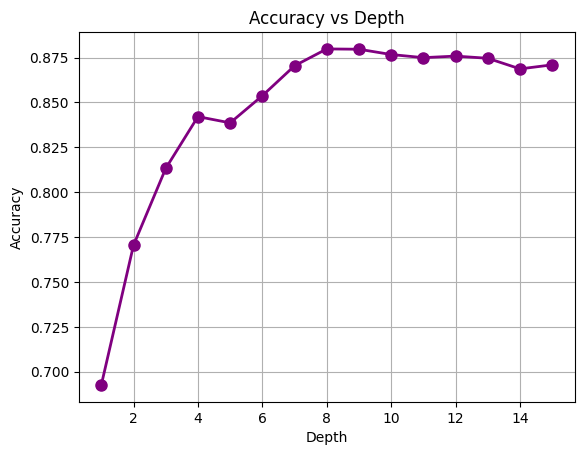

In [2]:
#########################imports#######################################################################
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
df1 = pd.read_csv("Q1Data.csv")
X1 = df1.iloc[:, 0:6].values
Y1= df1['Genus'].values
label_encoder = LabelEncoder()
Y1 = label_encoder.fit_transform(Y1)
X_train1, X_test1, Y_train1, Y_test1 = train_test_split(X1, Y1, test_size=0.8, random_state=42)
test_performance=[]
test_depths = [m for m in range(1, 16)]
######################Node  definitions###################################################################
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,*,value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

#########################Decision Tree#####################################################################################
class D_Tree:
    def __init__(self, min_split,max_depth,n_features=None):

        self.min_split=min_split
        self.max_depth=max_depth
        self.n_features=n_features
        self.root=None


    def fit(self,X,Y):
        columns = X.shape[1]
        row    = X.shape[0]
        self.n_features = columns
        dummy = self.build_tree(X,Y)
        self.root = dummy

    def build_tree(self,X,Y,depth=0):
        n_samples, n_feats = X.shape
        n_labels = len(np.unique(Y))

        label_counts = {}

        for label in Y:
            if label in label_counts:
                  label_counts[label] += 1
            else:
                  label_counts[label] = 1

        majority_element = max(label_counts, key=label_counts.get)

        if depth >= self.max_depth:
            leaf_majority = majority_element
            return Node(value = leaf_majority)
        elif n_labels == 1:
            leaf_majority = majority_element
            return Node(value = leaf_majority)
        elif n_samples < self.min_split:
            leaf_majority = majority_element
            return Node(value = leaf_majority)

        selected_features_order = np.random.choice(n_feats, self.n_features, replace=False)
        best_feature, best_thresh = self._best_split(X, Y, selected_features_order)
        temp1 = X[:, best_feature]
        left_idxs  = np.where( temp1 <= best_thresh)[0]
        right_idxs  = np.where(temp1 > best_thresh)[0]
        left = self.build_tree(X[left_idxs, :], Y[left_idxs], depth+1)
        right = self.build_tree(X[right_idxs, :], Y[right_idxs], depth+1)
        return Node(best_feature, best_thresh, left, right)

    def _best_split(self, X, Y, selected_features_order):
        best_gain = -1
        split_idx, split_threshold = None, None

        for ind_feat in selected_features_order:
            X_column = X[:, ind_feat]
            thresholds = np.unique(X_column)

            for thr in thresholds:

                gain = self._information_gain(Y, X_column, thr)

                if gain > best_gain:
                    best_gain = gain
                    split_idx = ind_feat
                    split_threshold = thr

        return split_idx, split_threshold

    def _information_gain(self,Y,X_column,threshold):
      total_count = len(Y)
      parent_gini = self.gini_impurity(Y)

      left_index = np.where(X_column <= threshold)[0]
      right_index = np.where(X_column > threshold)[0]
      left_count = len(left_index)
      right_count = len(right_index)
      if left_count == 0 or right_count == 0:
          return 0
      gini_left = self.gini_impurity(Y[left_index])
      gini_right = self.gini_impurity(Y[right_index])
      left_prob = left_count/total_count
      right_prob = right_count/total_count
      child_gini = left_prob * gini_left + right_prob*gini_right
      info_gain = parent_gini - child_gini
      return info_gain

    def gini_impurity(self, Y):
        hist = np.bincount(Y)
        ps = hist / len(Y)
        return 1.0 - np.sum(np.square(ps))


    def predict(self, X):
        predictions = []
        for x in X:
          predictions.append(self._individual_tree(x, self.root))
        return np.array(predictions)

    def _individual_tree(self, x, node):
         while node.value is  None:
             if x[node.feature] <= node.threshold:
                  node = node.left
             else:
                  node = node.right
         return node.value
#####################################DRIVER###########################################################################3

for depth in test_depths:
    correct_predictions = 0
    D_tree_object = D_Tree(min_split=10,max_depth=depth,n_features=21)
    D_tree_object.fit(X_train1, Y_train1)
    predictions = D_tree_object.predict(X_test1)
    for pred, true_label in zip(predictions, Y_test1):
       if pred == true_label:
           correct_predictions += 1

    accuracy = correct_predictions / len(Y_test1)

    test_performance.append(accuracy)

#print(len(test_depths))
#print(len(test_performance))

#####################################Plotting######################################################################
plt.plot(test_depths, test_performance, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
plt.title('Accuracy vs Depth')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid(True)
plt.show()


######################################################################################################################


# **KNN CLASSIFIER**



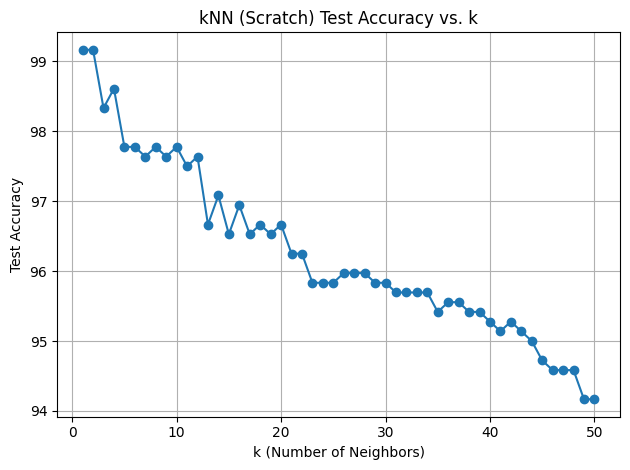

In [6]:
########################IMPORT AND LOAD DATA SET##########################################################
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder
# import matplotlib.pyplot as plt
# from collections import Counter
df2 = pd.read_csv("Q1Data-part2.csv")
df2 = df2.sample(frac=0.4, random_state=42)
X2 = df2.iloc[:, 1:-3].values
Y2= df2['Genus'].values
label_encoder = LabelEncoder()
Y2 = label_encoder.fit_transform(Y2)
X_train2, X_test2, Y_train2, Y_test2 = train_test_split(X2, Y2, test_size=0.25, random_state=42)
k_max = 50
k_range = list(range(1, k_max + 1))
test_performance_knn = []
#########################################################################################################################
def euclid(x1, x2):
    distance = 0.0
    for i in range(len(x1)):
        distance += (x1[i] - x2[i]) ** 2
    distance = np.sqrt(distance)
    return distance


def knn_prediction(X_test, X_train, Y_train, k):
    predictions = []
    for ind_test_vectors in X_test:
        distance_list = []
        for ind_vectors in X_train:
            distance_list.append(euclid(ind_vectors, ind_test_vectors))

        k_nearest = np.argsort(distance_list)[:k]
        k_labels = Y_train[k_nearest]

        most_common = Counter(k_labels).most_common()
        prediction = most_common[0][0]
        predictions.append(prediction)
    return predictions

for k in k_range:
    predictions = knn_prediction(X_test2, X_train2, Y_train2, k)
    accuracy = np.mean(predictions == Y_test2)
    test_performance_knn.append(accuracy * 100)

plt.plot(k_range, test_performance_knn, marker='o', label='Scratch')
plt.title('kNN (Scratch) Test Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

# **COMPARISON (D-TREE SCRATCH VS D-TREE LIB) (KNN SCRATCH VS KNN LIB)**

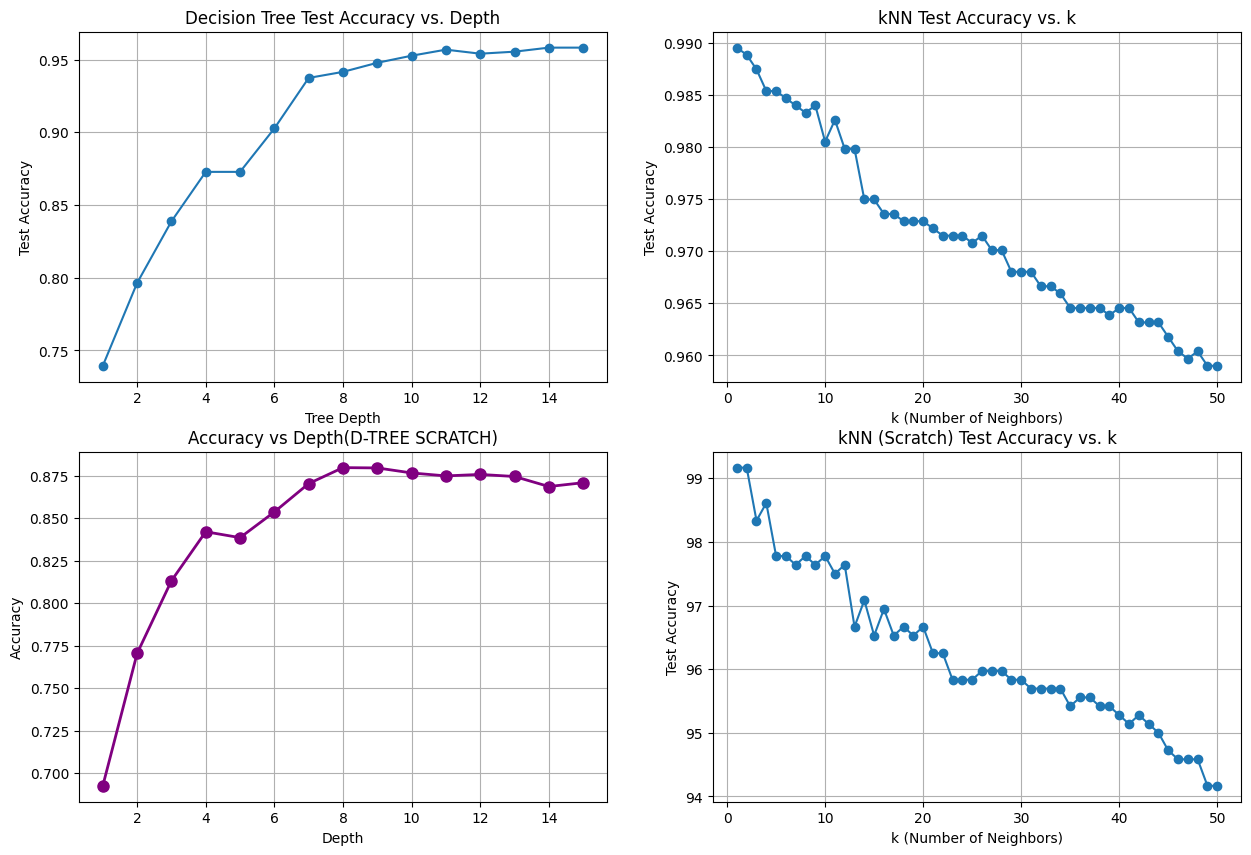

In [7]:
########################IMPORT AND LOAD DATA SET##########################################################
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder
# import matplotlib.pyplot as plt
# from collections import Counter
df3 = pd.read_csv("Q1Data-part3.csv")
X3 = df3.iloc[:, 0:21].values
Y3= df3['Genus'].values
label_encoder = LabelEncoder()
Y3 = label_encoder.fit_transform(Y3)
X_train3, X_test3, Y_train3, Y_test3 = train_test_split(X3, Y3, test_size=0.2, random_state=42)
k_values_orig = list(range(1, k_max+1))
knn_accuracies_orig = []
dt_accuracies_orig = []
depths = list(range(1, 16))
#########################################################################################################################
for depth in depths:
    dt_classifier = DecisionTreeClassifier(max_depth=depth, random_state=42)
    dt_classifier.fit(X_train3, Y_train3)
    dt_predictions = dt_classifier.predict(X_test3)
    dt_accuracy = accuracy_score(Y_test3, dt_predictions)
    dt_accuracies_orig.append(dt_accuracy)

for k in k_values_orig:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    knn_classifier.fit(X_train3, Y_train3)
    knn_predictions = knn_classifier.predict(X_test3)
    knn_accuracy_orig = accuracy_score(Y_test3, knn_predictions)
    knn_accuracies_orig.append(knn_accuracy_orig)

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(depths, dt_accuracies_orig, marker='o')
plt.title('Decision Tree Test Accuracy vs. Depth')
plt.xlabel('Tree Depth')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(k_values_orig, knn_accuracies_orig, marker='o')
plt.title('kNN Test Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(test_depths, test_performance, marker='o', color='purple', linestyle='-', linewidth=2, markersize=8)
plt.title('Accuracy vs Depth(D-TREE SCRATCH)')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.grid(True)


plt.subplot(2, 2, 4)
plt.plot(k_range, test_performance_knn, marker='o', label='Scratch')
plt.title('kNN (Scratch) Test Accuracy vs. k')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Test Accuracy')
plt.grid(True)

